# Prepare run

## Import libraries and functions

In [1]:
import os
import re
import keras
import scipy
import pickle
import crested
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
from crested.tl.data import AnnDataModule
from crested.tl import default_configs, TaskConfig

import matplotlib
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

## Setup directories

Download the data for the notebooks from the dedicated Zenodo link of the CREsted paper. Then use it below.

In [ ]:
data_dir = Path("../../../crested_data/Figure_4/deepccl")

output_dir = Path(f'results/topic_scoring')
output_path = data_dir.joinpath(output_dir)

deepccl_dir = Path(f'results/models')
deepccl_path = data_dir.joinpath(deepccl_dir)

Load hg38 genome

This notebook requires an hg38 fasta file and an hg38 chromosome sizes file. You can download that here for example: https://hgdownload.soe.ucsc.edu/downloads.html Once downloaded, we load them to the notebook.

In [ ]:
genome_dir = "../../../human/genome/"
genome_fasta = f"{genome_dir}hg38.fa"
genome_chrom_sizes  = f"{genome_dir}hg38.chrom.sizes"

genome = crested.Genome(genome_fasta, genome_chrom_sizes)
crested.register_genome(genome)

# Matching biopsy topics with the cell line accessibility and DeepCCL predictions (Figure S11c)

## Obtain predictions/coverage

This step can be skipped since we already have calculated the predictions/accessibility for each topic and we can load them directly.

### Prediction-based

In [21]:
ps_corrs = {}
sp_corrs = {}
topics = []
labels = ['A172', 'GM12878', 'HepG2', 'LN229', 'M059J', 'MM001', 'MM029', 'MM099']
classes_of_interest = ['a172', 'gm12878', 'hepg2', 'ln229', 'm059j', 'mm001', 'mm029', 'mm099']
sel_topics = ['topic8', 'topic21', 'topic25', 'topic5', 'topic14', 'topic19']

topics_to_dars = {}
mes_topics = [1, 8, 10, 15, 17, 21]
ac_topics = [2, 4, 5, 13, 20, 22, 25]
opc_topics = [3, 6, 7, 9, 11, 12, 14, 16, 18, 19, 23, 24]

for topic in mes_topics:
    topics_to_dars[topic] = 'mes'
for topic in ac_topics:
    topics_to_dars[topic] = 'ac'
for topic in opc_topics:
    topics_to_dars[topic] = 'opc'

for label in labels:
    ps_corrs[label] = []
    sp_corrs[label] = []

In [22]:
topk = 10000
print(f'Predicting top {topk}')
y_pred = np.zeros(shape=(topk, 25, 8))
y_true = np.zeros(shape=(topk, 25))

for topic_num in range(1, 26):
    topics.append(f'Topic{topic_num}')
    print(f'Predicting Topic {topic_num}')
    topic_dars = topics_to_dars[topic_num]

    adata = crested.import_bigwigs(
        bigwigs_folder=output_path.joinpath(Path(f"bigwigs/bigwig_topic{topic_num}")),
        regions_file=output_path.joinpath(Path(f"dars/{topic_dars}_{topk}.bed")),
        chromsizes_file=genome_chrom_sizes,
        target_region_width=500,
        target="mean",
    )

    adata_expanded = anndata.AnnData(
        X=np.tile(adata.X, (8, 1)),
        obs=adata.obs.iloc[np.tile(np.arange(adata.n_obs), 8)].reset_index(drop=True),
        var=adata.var
    )
    adata_expanded.obs_names = labels
    crested.pp.change_regions_width(
        adata_expanded,
        2114,
        chromsizes_file=genome_chrom_sizes,
    )
    datamodule = AnnDataModule(
        adata_expanded,
        chromsizes_file=genome_chrom_sizes,
        batch_size=256,
        max_stochastic_shift=0,
        always_reverse_complement=False,
    )

    evaluator = crested.tl.Crested(data=datamodule)
    evaluator.load_model(
        deepccl_path.joinpath(Path("DeepCCL.keras")),
        compile=True,
    )
    evaluator.predict(
        adata_expanded,
        model_name="DeepCCL"
    )

    # Log-transform values
    x = adata_expanded.X[0, :].flatten()
    x = np.log1p(x)
    y_true[:x.shape[0], topic_num - 1] = x

    predicted_values = {
        adata_expanded.obs_names[idx]: adata_expanded.layers['DeepCCL'][idx, :]
        for idx in range(8) 
    }

    for model_idx, model in enumerate(predicted_values):
        predicted_values[model] = np.log1p(predicted_values[model])
        y_pred[:x.shape[0], topic_num - 1, model_idx] = predicted_values[model]

    # Get spearman and pearson correlations
    for model_name, y in predicted_values.items():
        pearson_corr, _ = stats.pearsonr(x, y)
        spearman_corr, _ = stats.spearmanr(x, y)
        ps_corrs[model_name].append(float(pearson_corr))
        sp_corrs[model_name].append(float(spearman_corr))

Predicting top 10000
Predicting Topic 1
2025-03-30T22:22:58.053108+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
2025-03-30T22:23:07.652604+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 2
2025-03-30T22:23:08.321412+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step
2025-03-30T22:26:26.082148+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 3
2025-03-30T22:26:26.658990+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step
2025-03-30T22:29:23.556984+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 4
2025-03-30T22:29:23.843072+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
2025-03-30T22:29:43.713207+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 5
2025-03-30T22:29:43.955569+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
2025-03-30T22:30:11.871464+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 6
2025-03-30T22:30:12.146540+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step
2025-03-30T22:32:13.653923+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 7
2025-03-30T22:32:14.009028+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
2025-03-30T22:32:51.670743+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 8
2025-03-30T22:32:51.924879+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
2025-03-30T22:33:10.628971+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 9
2025-03-30T22:33:10.939873+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
2025-03-30T22:33:38.287550+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 10
2025-03-30T22:33:38.700825+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
2025-03-30T22:34:04.804540+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 11
2025-03-30T22:34:05.070607+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
2025-03-30T22:34:41.109716+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 12
2025-03-30T22:34:41.357336+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
2025-03-30T22:36:02.825977+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 13
2025-03-30T22:36:03.108059+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
2025-03-30T22:36:44.815289+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 14
2025-03-30T22:36:45.055281+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
2025-03-30T22:38:32.479237+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 15
2025-03-30T22:38:32.774818+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step
2025-03-30T22:39:29.324557+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 16
2025-03-30T22:39:29.654532+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
2025-03-30T22:40:31.852637+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 17
2025-03-30T22:40:32.152417+0200 INFO Extracting values from 1 bigWig files...
2025-03-30T22:40:47.080588+0200 WARNING 2 consensus regions have no values in any bigWig file


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
2025-03-30T22:40:53.767408+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 18
2025-03-30T22:40:54.083902+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
2025-03-30T22:42:42.596361+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 19
2025-03-30T22:42:42.852475+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
2025-03-30T22:43:22.576815+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 20
2025-03-30T22:43:22.856386+0200 INFO Extracting values from 1 bigWig files...
2025-03-30T22:43:27.534040+0200 WARNING 1 consensus regions have no values in any bigWig file


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
2025-03-30T22:43:34.240201+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 21
2025-03-30T22:43:34.503549+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
2025-03-30T22:44:17.562159+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 22
2025-03-30T22:44:18.005480+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step
2025-03-30T22:46:45.836065+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 23
2025-03-30T22:46:46.101952+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
2025-03-30T22:47:20.685365+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 24
2025-03-30T22:47:21.029581+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
2025-03-30T22:47:46.369506+0200 INFO Adding predictions to anndata.layers[DeepCCL].
Predicting Topic 25
2025-03-30T22:47:46.640659+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_554675/1468451940.py:43: DeprecationWarning: The `predict` method is deprecated and will be removed from this class in a future version. Use the standalone function `tl.predict()` instead.
  evaluator.predict(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
2025-03-30T22:48:07.004271+0200 INFO Adding predictions to anndata.layers[DeepCCL].


Save results

In [23]:
np.save(output_path.joinpath(Path('topicdars_ypred.npy')), y_pred)
np.save(output_path.joinpath(Path('topicdars_ytrue.npy')), y_true)

### ATAC-based

In [24]:
ps_corrs = {}
sp_corrs = {}
topics = []
labels = ['A172', 'GM12878', 'HepG2', 'LN229', 'M059J', 'MM001', 'MM029', 'MM099']
classes_of_interest = ['a172', 'gm12878', 'hepg2', 'ln229', 'm059j', 'mm001', 'mm029', 'mm099']
sel_topics = ['topic8', 'topic21', 'topic25', 'topic5', 'topic14', 'topic19']

topics_to_dars = {}
mes_topics = [1, 8, 10, 15, 17, 21]
ac_topics = [2, 4, 5, 13, 20, 22, 25]
opc_topics = [3, 6, 7, 9, 11, 12, 14, 16, 18, 19, 23, 24]

for topic in mes_topics:
    topics_to_dars[topic] = 'mes'
for topic in ac_topics:
    topics_to_dars[topic] = 'ac'
for topic in opc_topics:
    topics_to_dars[topic] = 'opc'

for label in labels:
    ps_corrs[label] = []
    sp_corrs[label] = []

In [25]:
topk = 10000
print(f'Correlating top {topk}')
y_pred = np.zeros(shape=(topk, 25, 8))
y_true = np.zeros(shape=(topk, 25))

for topic_num in range(1, 26):
    topics.append(f'Topic{topic_num}')
    print(f'Predicting Topic {topic_num}')
    topic_dars = topics_to_dars[topic_num]

    adata = crested.import_bigwigs(
        bigwigs_folder=output_path.joinpath(Path(f"bigwigs/bigwig_topic{topic_num}")),
        regions_file=output_path.joinpath(Path(f"dars/{topic_dars}_{topk}.bed")),
        chromsizes_file=genome_chrom_sizes,
        target_region_width=500,
        target="mean",
    )

    adata_bw = crested.import_bigwigs(
        bigwigs_folder=data_dir.joinpath(Path("bigwigs")),
        regions_file=output_path.joinpath(Path(f"dars/{topic_dars}_{topk}.bed")),
        chromsizes_file=genome_chrom_sizes,
        target_region_width=500,
        target="mean",
    )

    adata_expanded = anndata.AnnData(
        X=np.tile(adata.X, (8, 1)),
        obs=adata.obs.iloc[np.tile(np.arange(adata.n_obs), 8)].reset_index(drop=True),
        var=adata.var
    )
    adata_expanded.obs_names = labels

    # Log-transform values
    x = adata_expanded.X[0, :].flatten()
    x = np.log1p(x)
    y_true[:, topic_num - 1] = x

    bw_values = {
        adata_expanded.obs_names[idx]: adata_bw.X[idx, :]
        for idx in range(8) 
    }

    for cell_idx, cell_line in enumerate(bw_values):
        bw_values[cell_line] = np.log1p(bw_values[cell_line])
        y_pred[:, topic_num - 1, cell_idx] = bw_values[cell_line]

    # Get spearman and pearson correlations
    for cell_line, y in bw_values.items():
        pearson_corr, _ = stats.pearsonr(x, y)
        spearman_corr, _ = stats.spearmanr(x, y)
        ps_corrs[cell_line].append(float(pearson_corr))
        sp_corrs[cell_line].append(float(spearman_corr))

Correlating top 10000
Predicting Topic 1
2025-03-30T22:54:21.978676+0200 INFO Extracting values from 1 bigWig files...
2025-03-30T22:54:47.976794+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T22:59:33.727862+0200 WARNING 5 consensus regions have no values in any bigWig file


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Predicting Topic 2
2025-03-30T22:59:34.736884+0200 INFO Extracting values from 1 bigWig files...
2025-03-30T23:00:50.886396+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:02:30.279542+0200 WARNING 4 consensus regions have no values in any bigWig file
Predicting Topic 3
2025-03-30T23:02:30.462031+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:02:32.896994+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:03:36.342746+0200 WARNING 14 consensus regions have no values in any bigWig file
Predicting Topic 4


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:03:36.565642+0200 INFO Extracting values from 1 bigWig files...
2025-03-30T23:03:38.879116+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:03:41.170954+0200 WARNING 4 consensus regions have no values in any bigWig file
Predicting Topic 5
2025-03-30T23:03:41.352405+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:03:43.756038+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:03:46.314470+0200 WARNING 4 consensus regions have no values in any bigWig file
Predicting Topic 6
2025-03-30T23:03:46.498341+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:03:48.949003+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:03:51.242161+0200 WARNING 14 consensus regions have no values in any bigWig file
Predicting Topic 7
2025-03-30T23:03:51.425048+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:03:53.808313+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:03:56.087849+0200 WARNING 14 consensus regions have no values in any bigWig file
Predicting Topic 8
2025-03-30T23:03:56.269546+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:03:58.644555+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:04:01.264844+0200 WARNING 5 consensus regions have no values in any bigWig file
Predicting Topic 9
2025-03-30T23:04:01.446453+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:04:03.819691+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:04:06.090247+0200 WARNING 14 consensus regions have no values in any bigWig file
Predicting Topic 10
2025-03-30T23:04:06.275377+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:04:08.740549+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:04:11.121622+0200 WARNING 5 consensus regions have no values in any bigWig file
Predicting Topic 11
2025-03-30T23:04:11.304932+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:04:13.736643+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:04:16.269690+0200 WARNING 14 consensus regions have no values in any bigWig file
Predicting Topic 12
2025-03-30T23:04:16.453074+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:04:18.899234+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:04:21.190551+0200 WARNING 14 consensus regions have no values in any bigWig file
Predicting Topic 13
2025-03-30T23:04:21.373809+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:04:23.810033+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:04:26.130601+0200 WARNING 4 consensus regions have no values in any bigWig file
Predicting Topic 14
2025-03-30T23:04:26.314940+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:04:28.810109+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:04:31.379890+0200 WARNING 14 consensus regions have no values in any bigWig file
Predicting Topic 15
2025-03-30T23:04:31.563039+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:04:34.016526+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:04:36.404084+0200 WARNING 5 consensus regions have no values in any bigWig file
Predicting Topic 16
2025-03-30T23:04:36.590700+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:04:39.041742+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:04:41.354894+0200 WARNING 14 consensus regions have no values in any bigWig file
Predicting Topic 17
2025-03-30T23:04:41.536757+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:04:43.760452+0200 WARNING 2 consensus regions have no values in any bigWig file
2025-03-30T23:04:43.926379+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:04:46.560972+0200 WARNING 5 consensus regions have no values in any bigWig file
Predicting Topic 18
2025-03-30T23:04:46.742242+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:04:49.271455+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:04:51.576066+0200 WARNING 14 consensus regions have no values in any bigWig file
Predicting Topic 19
2025-03-30T23:04:51.755757+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:04:54.190512+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:04:56.477264+0200 WARNING 14 consensus regions have no values in any bigWig file
Predicting Topic 20
2025-03-30T23:04:56.660686+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:04:58.694959+0200 WARNING 1 consensus regions have no values in any bigWig file
2025-03-30T23:04:58.862470+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:05:02.267691+0200 WARNING 4 consensus regions have no values in any bigWig file
Predicting Topic 21
2025-03-30T23:05:02.451784+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:05:04.934951+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:05:07.301794+0200 WARNING 5 consensus regions have no values in any bigWig file
Predicting Topic 22
2025-03-30T23:05:07.487816+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:05:09.927014+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:05:12.209449+0200 WARNING 4 consensus regions have no values in any bigWig file
Predicting Topic 23
2025-03-30T23:05:12.392792+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:05:14.833135+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:05:17.348752+0200 WARNING 14 consensus regions have no values in any bigWig file
Predicting Topic 24
2025-03-30T23:05:17.530397+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:05:19.892094+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:05:22.173684+0200 WARNING 14 consensus regions have no values in any bigWig file
Predicting Topic 25
2025-03-30T23:05:22.356560+0200 INFO Extracting values from 1 bigWig files...


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


2025-03-30T23:05:24.723345+0200 INFO Extracting values from 8 bigWig files...
2025-03-30T23:05:27.030454+0200 WARNING 4 consensus regions have no values in any bigWig file


/staging/leuven/stg_00002/lcb/vkonst/software/anaconda3/envs/crested_paper/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Save results

In [26]:
np.save(output_path.joinpath(Path('bw_topicdars_ypred.npy')), y_pred)
np.save(output_path.joinpath(Path('bw_topicdars_ytrue.npy')), y_true)

## DeepCCL predictions (Figure S11c, left)

In [27]:
# Define dictionary to store results
ps_corrs = {}
sp_corrs = {}
labels = ['A172', 'GM12878', 'HepG2', 'LN229', 'M059J', 'MM001', 'MM029', 'MM099']

mes_topics = [8, 21, 1, 10, 15, 17]
ac_topics = [25, 20, 2, 4, 5, 13, 22]
opc_topics = [14, 18, 19, 3, 6, 7, 9, 11, 12, 16, 23, 24]

for label in labels:
    ps_corrs[label] = []
    sp_corrs[label] = []

# Load predictions and atac (we already calculated the predictions based on the previous step)
y_topic_pred = np.load(output_path.joinpath(Path('topicdars_ypred.npy')))
y_topic_true = np.load(output_path.joinpath(Path('topicdars_ytrue.npy')))

# Get average predictions
gbm_mes_like = (y_topic_pred[:, :, 0] + y_topic_pred[:, :, 4])/2
mel_mes_like = (y_topic_pred[:, :, 6] + y_topic_pred[:, :, 7])/2
gbm_all = (y_topic_pred[:, :, 0] + y_topic_pred[:, :, 3] + y_topic_pred[:, :, 4])/3
mes_like = (y_topic_pred[:, :, 0] + y_topic_pred[:, :, 4] + y_topic_pred[:, :, 6] + y_topic_pred[:, :, 7])/4

# Gather in a dataframe
for i in range(len(labels)):
    for col in range(y_topic_true.shape[1]):
        sp_corrs[labels[i]].append(float(stats.spearmanr(y_topic_true[:, col], y_topic_pred[:, col, i])[0]))

sp_corrs['GBM'] = []
for col in range(y_topic_true.shape[1]):
    sp_corrs['GBM'].append(float(stats.spearmanr(y_topic_true[:, col], gbm_all[:, col])[0]))

sp_corrs['MES-like'] = []
for col in range(y_topic_true.shape[1]):
    sp_corrs['MES-like'].append(float(stats.spearmanr(y_topic_true[:, col], mes_like[:, col])[0]))

sp_corrs['GBM MES-like'] = []
for col in range(y_topic_true.shape[1]):
    sp_corrs['GBM MES-like'].append(float(stats.spearmanr(y_topic_true[:, col], gbm_mes_like[:, col])[0]))

sp_corrs['MEL MES-like'] = []
for col in range(y_topic_true.shape[1]):
    sp_corrs['MEL MES-like'].append(float(stats.spearmanr(y_topic_true[:, col], mel_mes_like[:, col])[0]))

# Prepare dataframe for plotting
sp_df = pd.DataFrame(index=sp_corrs.keys(), data=sp_corrs.values(), columns=[f'Topic{x}' for x in range(1, 26)]).T
selected_classes = ['GBM', 'GBM MES-like', 'MEL MES-like', 'LN229', 'HepG2']
topic_order = [f'Topic{x}' for x in mes_topics + ac_topics + opc_topics]
excluded_topics = ['Topic3', 'Topic17']  # Topics to remove

sp_df_sel = sp_df.loc[topic_order]
sp_df_sel = sp_df_sel.loc[~sp_df_sel.index.isin(excluded_topics), selected_classes]
sp_df_sel = sp_df_sel[::-1]

Barplot

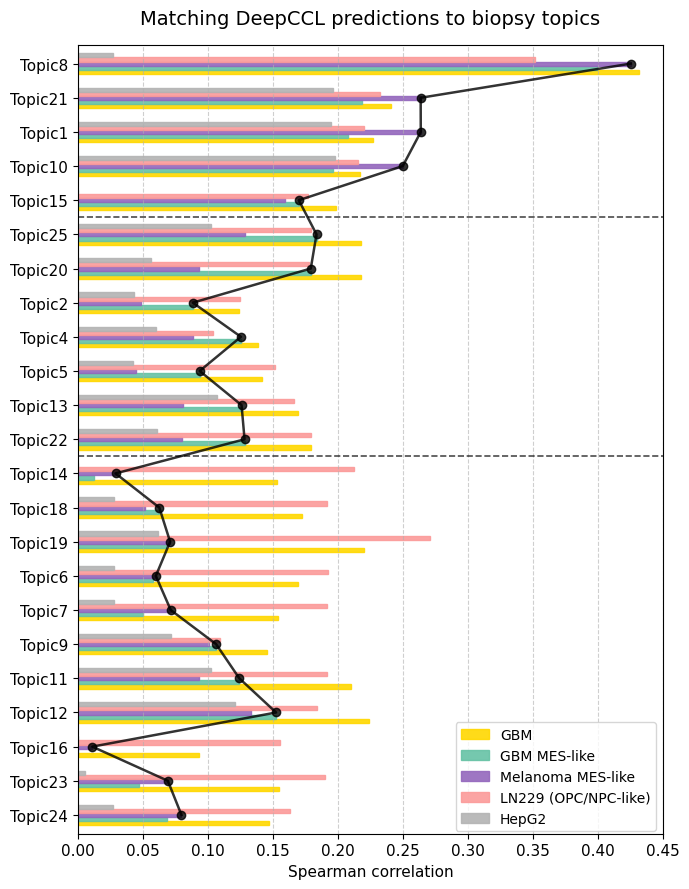

In [28]:
# Create a horizontal bar chart
ax = sp_df_sel.plot(
    kind="barh",
    figsize=(7, 9),
    width=0.6,
    edgecolor="black",
)

# Define a color palette for each class
color_map = {
    "GBM": "gold",
    "GBM MES-like": "#66C2A5",  # Teal Green
    "MEL MES-like": "#9467bd",  # Soft Purple
    "LN229": "#FB9A99",  # Light Red
    "HepG2": "#B3B3B3",  # Gray
}

# Assign colors dynamically based on their labels
bars = ax.patches
bar_labels = sp_df_sel.columns.repeat(len(sp_df_sel))

for bar, label in zip(bars, bar_labels):
    bar.set_color(color_map[label])
    bar.set_alpha(0.9)
    bar.set_linewidth(1)

# Add reference lines with enhanced styling
plt.axvline(0, color="black", linewidth=1.2)
plt.axhline(10.5, color="black", linewidth=1.2, linestyle='--', alpha=0.7)
plt.axhline(17.5, color="black", linewidth=1.2, linestyle='--', alpha=0.7)

# Subtle grid for better readability
ax.grid(axis="x", linestyle="--", alpha=0.6)

# Set limits for x-axis with better padding
plt.xlim(0, 0.45)

# Improve title and labels
plt.title("Matching DeepCCL predictions to biopsy topics", fontsize=14, pad=15)
plt.xlabel("Spearman correlation", fontsize=11)
# plt.ylabel("Topics", fontsize=11)

handles, _ = ax.get_legend_handles_labels()
new_labels = ["GBM", "GBM MES-like", "Melanoma MES-like", "LN229 (OPC/NPC-like)", "HepG2"]
ax.legend(handles, new_labels, bbox_to_anchor=(1, 0.15))

# Customize ticks
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Get the max MES-like value for each topic and plot a reference line
top_values = sp_df_sel[['GBM MES-like', 'MEL MES-like']].max(axis=1).values
ax.plot(top_values, range(len(sp_df_sel)), color='black', marker='o', linestyle='-', linewidth=1.8, alpha=0.8)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## ATAC-seq (Figure S11c, right)

In [29]:
# Define dictionary to store results
ps_corrs = {}
sp_corrs = {}
labels = ['A172', 'GM12878', 'HepG2', 'LN229', 'M059J', 'MM001', 'MM029', 'MM099']

mes_topics = [8, 21, 1, 10, 15, 17]
ac_topics = [25, 20, 2, 4, 5, 13, 22]
opc_topics = [14, 18, 19, 3, 6, 7, 9, 11, 12, 16, 23, 24]

for label in labels:
    ps_corrs[label] = []
    sp_corrs[label] = []

# Load predictions and atac (we already calculated the predictions based on the previous step)
y_topic_pred = np.load(output_path.joinpath(Path('bw_topicdars_ypred.npy')))
y_topic_true = np.load(output_path.joinpath(Path('bw_topicdars_ytrue.npy')))

# Get average predictions
gbm_mes_like = (y_topic_pred[:, :, 0] + y_topic_pred[:, :, 4])/2
mel_mes_like = (y_topic_pred[:, :, 6] + y_topic_pred[:, :, 7])/2
gbm_all = (y_topic_pred[:, :, 0] + y_topic_pred[:, :, 3] + y_topic_pred[:, :, 4])/3
mes_like = (y_topic_pred[:, :, 0] + y_topic_pred[:, :, 4] + y_topic_pred[:, :, 6] + y_topic_pred[:, :, 7])/4

# Gather in a dataframe
for i in range(len(labels)):
    for col in range(y_topic_true.shape[1]):
        sp_corrs[labels[i]].append(float(stats.spearmanr(y_topic_true[:, col], y_topic_pred[:, col, i])[0]))

sp_corrs['GBM'] = []
for col in range(y_topic_true.shape[1]):
    sp_corrs['GBM'].append(float(stats.spearmanr(y_topic_true[:, col], gbm_all[:, col])[0]))

sp_corrs['MES-like'] = []
for col in range(y_topic_true.shape[1]):
    sp_corrs['MES-like'].append(float(stats.spearmanr(y_topic_true[:, col], mes_like[:, col])[0]))

sp_corrs['GBM MES-like'] = []
for col in range(y_topic_true.shape[1]):
    sp_corrs['GBM MES-like'].append(float(stats.spearmanr(y_topic_true[:, col], gbm_mes_like[:, col])[0]))

sp_corrs['MEL MES-like'] = []
for col in range(y_topic_true.shape[1]):
    sp_corrs['MEL MES-like'].append(float(stats.spearmanr(y_topic_true[:, col], mel_mes_like[:, col])[0]))

# Prepare dataframe for plotting
sp_df = pd.DataFrame(index=sp_corrs.keys(), data=sp_corrs.values(), columns=[f'Topic{x}' for x in range(1, 26)]).T
selected_classes = ['GBM', 'GBM MES-like', 'MEL MES-like', 'LN229', 'HepG2']
topic_order = [f'Topic{x}' for x in mes_topics + ac_topics + opc_topics]
excluded_topics = ['Topic3', 'Topic17']  # Topics to remove

sp_df_sel = sp_df.loc[topic_order]
sp_df_sel = sp_df_sel.loc[~sp_df_sel.index.isin(excluded_topics), selected_classes]
sp_df_sel = sp_df_sel[::-1]

Barplot

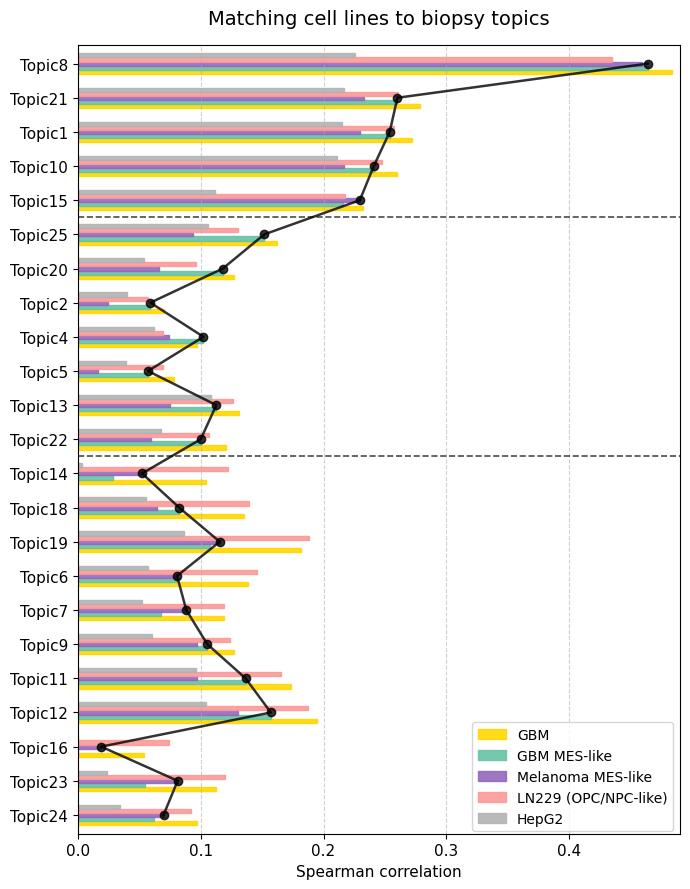

In [30]:
# Create a horizontal bar chart
ax = sp_df_sel.plot(
    kind="barh",
    figsize=(7, 9),
    width=0.6,
    edgecolor="black",
)

# Define a color palette for each class
color_map = {
    "GBM": "gold",
    "GBM MES-like": "#66C2A5",  # Teal Green
    "MEL MES-like": "#9467bd",  # Soft Purple
    "LN229": "#FB9A99",  # Light Red
    "HepG2": "#B3B3B3",  # Gray
}

# Assign colors dynamically based on their labels
bars = ax.patches
bar_labels = sp_df_sel.columns.repeat(len(sp_df_sel))

for bar, label in zip(bars, bar_labels):
    bar.set_color(color_map[label])
    bar.set_alpha(0.9)
    bar.set_linewidth(1)

# Add reference lines with enhanced styling
plt.axvline(0, color="black", linewidth=1.2)
plt.axhline(10.5, color="black", linewidth=1.2, linestyle='--', alpha=0.7)
plt.axhline(17.5, color="black", linewidth=1.2, linestyle='--', alpha=0.7)

# Subtle grid for better readability
ax.grid(axis="x", linestyle="--", alpha=0.6)

# Set limits for x-axis with better padding
plt.xlim(0, 0.49)

# Improve title and labels
plt.title("Matching cell lines to biopsy topics", fontsize=14, pad=15)
plt.xlabel("Spearman correlation", fontsize=11)
# plt.ylabel("Topics", fontsize=11)

handles, _ = ax.get_legend_handles_labels()
new_labels = ["GBM", "GBM MES-like", "Melanoma MES-like", "LN229 (OPC/NPC-like)", "HepG2"]
ax.legend(handles, new_labels, bbox_to_anchor=(1, 0.15))

# Customize ticks
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Get the max MES-like value for each topic and plot a reference line
top_values = sp_df_sel[['GBM MES-like', 'MEL MES-like']].max(axis=1).values
ax.plot(top_values, range(len(sp_df_sel)), color='black', marker='o', linestyle='-', linewidth=1.8, alpha=0.8)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()